In [ ]:
!pip install numpy opencv-python scikit-image matplotlib SimpleITK pywavelets gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 90.7 MB/s eta 0:00:00


In [ ]:
import json
from collections import deque

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import pandas as pd
from skimage import segmentation, color
from skimage.feature import local_binary_pattern
from skimage.measure import label
from skimage.morphology import closing, opening, footprint_rectangle, remove_small_objects
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

## 1 - Download Cityscapes dataset

In [ ]:
!gdown 1ZuT5fGzLwwnHhZ3ANa2Cmsoz9Wy66Io6
!gdown 1yqB8yZTC1v7G9gQ-5OohLcaC5WnEnyH2
!unzip -o gtFine_trainval.zip
!unzip -o leftImg8bit_trainval.zip

Streaming output truncated to the last 5000 lines.
  inflating: gtFine_train_all/strasbourg_000000_013863_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_013944_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014066_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014101_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014235_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014416_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014503_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014584_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014743_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_014931_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_015131_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_015506_gtFine_color.png  
  inflating: gtFine_train_all/strasbourg_000000_015602_gtFine

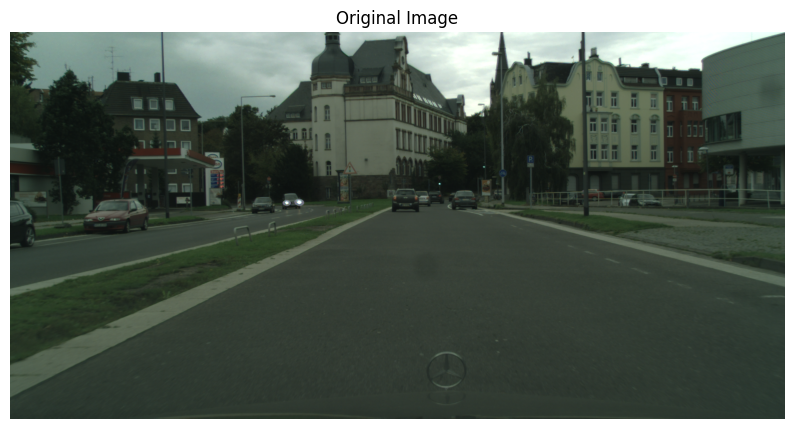

In [ ]:
image_path = '/content/leftImg8bit_train_all/aachen_000001_000019_leftImg8bit.png'
color_annotation_path = '/content/gtFine_train_all/aachen_000001_000019_gtFine_color.png'
# Testing on other images using the algorithm can be performed by changing the paths to the ones of other images and masks in the leftImg8bit_train_all and gtFine_train_all folders
# i.g.: aachen_000002_000019_leftImg8bit.png, aachen_000002_000019_gtFine_color.png and so on

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

## 2 - Region growing pipeline

### 2.1 - Preprocess the data

In [ ]:
class Preprocessor:
    def __init__(self):
        pass

    def load_image(self, image_path):
        image_bgr = cv2.imread(image_path)
        if image_bgr is None:
            raise ValueError("Image not found or path is incorrect.")
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        return image_rgb

    def convert_to_lab(self, img_rgb):
        return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

    def compute_gradient_magnitude_lab(self, img_lab):
        L_channel = img_lab[:, :, 0]
        L_blurred = cv2.GaussianBlur(L_channel, (5, 5), 0)
        sobel_x = cv2.Sobel(L_blurred, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(L_blurred, cv2.CV_64F, 0, 1, ksize=3)
        gradient = np.sqrt(sobel_x**2 + sobel_y**2)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX)
        return gradient.astype(np.uint8)

    def compute_edges(self, img_rgb, low_threshold=50, high_threshold=150):
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        return cv2.Canny(img_gray, low_threshold, high_threshold)

    def compute_texture_features(self, img_gray, P=8, R=1):
        return local_binary_pattern(img_gray, P, R, method='uniform')

### 2.2 - Perform region growing

In [ ]:
class RegionGrower:
    def __init__(self, threshold_ratio=0.3, min_size=50, color_threshold=7.5, texture_threshold=5):
        self.threshold_ratio = threshold_ratio
        self.min_size = min_size
        self.color_threshold = color_threshold
        self.texture_threshold = texture_threshold

    def identify_basins(self, gradient_magnitude):
        threshold_value = np.percentile(gradient_magnitude, self.threshold_ratio * 100)
        _, basins_mask = cv2.threshold(gradient_magnitude, threshold_value, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((3, 3), np.uint8)
        basins_mask = cv2.morphologyEx(basins_mask, cv2.MORPH_OPEN, kernel, iterations=2)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(basins_mask, connectivity=8)
        filtered_mask = np.zeros_like(basins_mask)
        filtered_centroids = []
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= self.min_size:
                filtered_mask[labels == i] = 255
                filtered_centroids.append((int(centroids[i][0]), int(centroids[i][1])))
        return filtered_mask, filtered_centroids

    def get_initial_seeds(self, img_lab, gradient_magnitude):
        basins_mask, centroids = self.identify_basins(gradient_magnitude)
        return centroids, basins_mask

    def place_seeds_evenly(self, segmented, num_seeds, grid_size=(10, 10)):
        height, width = segmented.shape
        grid_rows, grid_cols = grid_size
        cell_height = height // grid_rows
        cell_width = width // grid_cols
        new_seeds = []

        for i in range(grid_rows):
            for j in range(grid_cols):
                start_y = i * cell_height
                end_y = (i + 1) * cell_height if i < grid_rows - 1 else height
                start_x = j * cell_width
                end_x = (j + 1) * cell_width if j < grid_cols - 1 else width

                cell_mask = segmented[start_y:end_y, start_x:end_x]
                if np.any(cell_mask == 0):
                    y_indices, x_indices = np.where(cell_mask == 0)
                    if len(y_indices) == 0:
                        continue
                    centroid_y = int(y_indices.mean()) + start_y
                    centroid_x = int(x_indices.mean()) + start_x
                    new_seeds.append((centroid_x, centroid_y))

        print(f"Placed {len(new_seeds)} new seeds in unlabeled regions.")
        return new_seeds

    def multi_seed_region_growing(self, img_lab, seed_points, edges, texture_features, segmented=None):
        if segmented is None:
            segmented = np.zeros(img_lab.shape[:2], dtype=np.int32)
        sum_colors = {}
        counts = {}
        current_label = 1
        neighbors = [(-1, -1), (0, -1), (1, -1),
                     (-1,  0),          (1,  0),
                     (-1,  1), (0,  1), (1,  1)]

        for seed in seed_points:
            x, y = seed
            if 0 <= x < img_lab.shape[1] and 0 <= y < img_lab.shape[0] and segmented[y, x] == 0:
                queue = deque()
                queue.append((x, y))
                segmented[y, x] = current_label
                seed_color = img_lab[y, x].astype(np.int32)
                sum_colors[current_label] = seed_color.copy()
                counts[current_label] = 1

                while queue:
                    cx, cy = queue.popleft()
                    for dx, dy in neighbors:
                        xn, yn = cx + dx, cy + dy
                        if 0 <= xn < img_lab.shape[1] and 0 <= yn < img_lab.shape[0]:
                            if segmented[yn, xn] == 0 and edges[yn, xn] == 0:
                                neighbor_color = img_lab[yn, xn].astype(np.int32)
                                avg_color = sum_colors[current_label] / counts[current_label]
                                avg_texture = texture_features[cy, cx]
                                neighbor_texture = texture_features[yn, xn]

                                color_diff = np.linalg.norm(avg_color - neighbor_color)
                                texture_diff = abs(avg_texture - neighbor_texture)
                                combined_diff = 0.7 * color_diff + 0.3 * texture_diff

                                if (color_diff < self.color_threshold and
                                    texture_diff < self.texture_threshold and
                                    combined_diff < (self.color_threshold + self.texture_threshold)):
                                    segmented[yn, xn] = current_label
                                    queue.append((xn, yn))
                                    sum_colors[current_label] += neighbor_color
                                    counts[current_label] += 1

                current_label += 1
        num_labels = current_label - 1
        return segmented, sum_colors, counts, num_labels

    def iterative_region_growing(self, image_lab, image_rgb, texture_features, edges, segmented, num_labels, grid_size, max_iter=10):
        iter_count = 0
        while np.any(segmented == 0) and iter_count < max_iter:
            new_seeds = self.place_seeds_evenly(segmented, num_seeds=100, grid_size=grid_size)
            if not new_seeds:
                print("No new seeds found. Terminating iterative region growing.")
                break

            segmented, sum_colors, counts, new_labels = self.multi_seed_region_growing(image_lab, new_seeds, edges, texture_features, segmented=segmented)
            iter_count += 1
            print(f"Iteration {iter_count}: added {new_labels} new regions. Total regions: {num_labels + new_labels}")

            if new_labels == 0:
                print("No new regions added. Stopping iterative region growing.")
                break

            num_labels += new_labels

        if np.all(segmented != 0):
            print("All pixels have been labeled (union reached).")
        else:
            print("Iterative region growing stopped (max iterations reached or no new seeds).")

        return segmented, num_labels

### 2.3 - Perform region merging

In [ ]:
class RegionMerger:
    def __init__(self, color_weight=0.5, texture_weight=0.3, spatial_weight=0.2, distance_threshold=0.5):
        self.color_weight = color_weight
        self.texture_weight = texture_weight
        self.spatial_weight = spatial_weight
        self.distance_threshold = distance_threshold

    def extract_features(self, img_lab, segmented, num_labels, texture_features):
        features = []
        for label in range(1, num_labels + 1):
            mask = segmented == label
            if not np.any(mask):
                continue
            avg_color = img_lab[mask].mean(axis=0)
            avg_texture = texture_features[mask].mean()
            coords = np.column_stack(np.where(mask))
            centroid_y, centroid_x = coords.mean(axis=0)
            features.append({
                'label': label,
                'avg_L': avg_color[0],
                'avg_A': avg_color[1],
                'avg_B': avg_color[2],
                'avg_texture': avg_texture,
                'centroid_x': centroid_x,
                'centroid_y': centroid_y
            })
        return pd.DataFrame(features)

    def prepare_similarity_matrix(self, features_df):
        color_features = features_df[['avg_L', 'avg_A', 'avg_B']].values
        color_features_norm = (color_features - color_features.mean(axis=0)) / color_features.std(axis=0)

        texture_features = features_df['avg_texture'].values.reshape(-1, 1)
        texture_features_norm = (texture_features - texture_features.mean()) / texture_features.std()

        spatial_features = features_df[['centroid_x', 'centroid_y']].values
        spatial_features_norm = (spatial_features - spatial_features.mean(axis=0)) / spatial_features.std(axis=0)

        weighted_color = self.color_weight * color_features_norm
        weighted_texture = self.texture_weight * texture_features_norm
        weighted_spatial = self.spatial_weight * spatial_features_norm

        X = np.hstack((weighted_color, weighted_texture, weighted_spatial))
        return X

    def perform_clustering(self, X):
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=self.distance_threshold,
            metric='euclidean',
            linkage='ward'
        )
        clustering.fit(X)
        return clustering.labels_

    def update_mask(self, segmented, features_df, clustering_labels):
        merged_segmented = np.zeros_like(segmented)
        label_mapping = {}
        for idx, row in features_df.iterrows():
            original_label = row['label']
            cluster_label = clustering_labels[idx]
            if cluster_label not in label_mapping:
                label_mapping[cluster_label] = len(label_mapping) + 1
            merged_label = label_mapping[cluster_label]
            merged_segmented[segmented == original_label] = merged_label
        merged_num_labels = len(label_mapping)
        return merged_segmented, merged_num_labels

    def merge_regions(self, segmented, img_lab, num_labels, texture_features):
        features_df = self.extract_features(img_lab, segmented, num_labels, texture_features)
        X = self.prepare_similarity_matrix(features_df)
        clustering_labels = self.perform_clustering(X)
        merged_segmented, merged_num_labels = self.update_mask(segmented, features_df, clustering_labels)
        print(f"Merged into {merged_num_labels} regions.")
        return merged_segmented, merged_num_labels

### 2.4 - Visualize the segmentation mask

In [ ]:
class Visualizer:
    @staticmethod
    def visualize_segmentation_step(img_rgb, segmented, num_labels, step_title):
        palette = np.random.randint(0, 255, size=(num_labels + 1, 3), dtype=np.uint8)
        palette[0] = [0, 0, 0]
        colored_mask = palette[segmented]
        overlay = cv2.addWeighted(img_rgb, 0.7, colored_mask, 0.3, 0)
        plt.figure(figsize=(10, 10))
        plt.imshow(overlay)
        plt.title(step_title, fontsize=16)
        plt.axis("off")
        plt.show()

    @staticmethod
    def visualize_gradient_and_basins(img_rgb, gradient_magnitude, basins_mask, seed_points, segmented, num_labels, step_title):
        img_plot = img_rgb.copy()
        for (x, y) in seed_points:
            cv2.circle(img_plot, (x, y), radius=3, color=(27, 161, 226), thickness=-1)

        palette = np.random.randint(0, 255, size=(num_labels + 1, 3), dtype=np.uint8)
        palette[0] = [0, 0, 0]
        colored_mask = palette[segmented]
        overlay = cv2.addWeighted(img_rgb, 0.7, colored_mask, 0.3, 0)

        plt.figure(figsize=(10, 10))
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title('Gradient Magnitude (L Channel)', fontsize=18)
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.imshow(basins_mask, cmap='gray')
        plt.title('Basins Mask (Low Gradient Areas)', fontsize=18)
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.imshow(img_plot)
        plt.title('Original Image with Seed Points', fontsize=18)
        plt.axis('off')
        plt.show()

### 2.5 - Segmentation pipeline

In [ ]:
class SegmentationPipeline:
    def __init__(self, image_path, threshold_ratio=0.5, min_size=50, color_threshold=10, texture_threshold=5,
                 low_edge_threshold=50, high_edge_threshold=150, color_weight=0.5, texture_weight=0.3,
                 spatial_weight=0.2, distance_threshold=0.5, grid_size=(10, 10)):
        self.image_path = image_path
        self.threshold_ratio = threshold_ratio
        self.min_size = min_size
        self.color_threshold = color_threshold
        self.texture_threshold = texture_threshold
        self.low_edge_threshold = low_edge_threshold
        self.high_edge_threshold = high_edge_threshold
        self.color_weight = color_weight
        self.texture_weight = texture_weight
        self.spatial_weight = spatial_weight
        self.distance_threshold = distance_threshold
        self.grid_size = grid_size

        self.preproc = Preprocessor()
        self.grower = RegionGrower(threshold_ratio, min_size, color_threshold, texture_threshold)
        self.merger = RegionMerger(color_weight, texture_weight, spatial_weight, distance_threshold)
        self.visualizer = Visualizer()

    def run(self):
        # Step 1: Load and preprocess the image
        image_rgb = self.preproc.load_image(self.image_path)
        image_lab = self.preproc.convert_to_lab(image_rgb)
        gradient_magnitude = self.preproc.compute_gradient_magnitude_lab(image_lab)
        edges = self.preproc.compute_edges(image_rgb, low_threshold=self.low_edge_threshold, high_threshold=self.high_edge_threshold)
        img_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        texture_features = self.preproc.compute_texture_features(img_gray, P=8, R=1)

        # Step 2: Initial seed selection via gradient magnitude map (low-gradient areas)
        seed_points, basins_mask = self.grower.get_initial_seeds(image_lab, gradient_magnitude)
        if not seed_points:
            raise ValueError("No basins found. Adjust threshold_ratio or min_size.")
        print(f"Initial seed selection found {len(seed_points)} seeds.")

        # Step 3: Initial region growing
        segmented_mask, sum_colors, counts, num_labels = self.grower.multi_seed_region_growing(image_lab, seed_points, edges, texture_features, segmented=None)
        print(f"Initial segmentation resulted in {num_labels} regions.")
        # OPTIONAL: Visualize the gradient magnitude map, the basins mask and the original image with seed points
        # self.visualizer.visualize_gradient_and_basins(image_rgb, gradient_magnitude, basins_mask, seed_points, segmented_mask, num_labels, "Before Initial Region Growing")
        self.visualizer.visualize_segmentation_step(image_rgb, segmented_mask, num_labels,"After Initial Region Growing")

        # Step 4: Perform iterative region growing until no new regions are added
        segmented_mask, num_labels = self.grower.iterative_region_growing(image_lab, image_rgb, texture_features, edges, segmented_mask, num_labels, grid_size=self.grid_size, max_iter=10)
        self.visualizer.visualize_segmentation_step(image_rgb, segmented_mask, num_labels, f"After Iterative Region Growing")

        # Step 5: Intelligent region merging
        merged_segmented, merged_num_labels = self.merger.merge_regions(segmented_mask, image_lab, num_labels, texture_features)
        self.visualizer.visualize_segmentation_step(image_rgb, merged_segmented, merged_num_labels, "After Intelligent Region Merging")
        print(f"Final segmentation resulted in {merged_num_labels} regions after merging.")

        return merged_segmented, merged_num_labels, image_rgb, gradient_magnitude, basins_mask

Initial seed selection found 732 seeds.
Initial segmentation resulted in 145 regions.


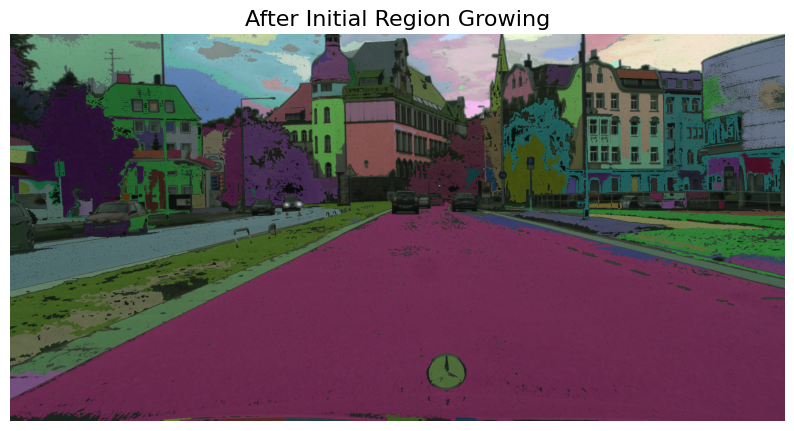

Placed 100 new seeds in unlabeled regions.
Iteration 1: added 22 new regions. Total regions: 167
Placed 100 new seeds in unlabeled regions.
Iteration 2: added 2 new regions. Total regions: 169
Placed 100 new seeds in unlabeled regions.
Iteration 3: added 0 new regions. Total regions: 169
No new regions added. Stopping iterative region growing.
Iterative region growing stopped (max iterations reached or no new seeds).


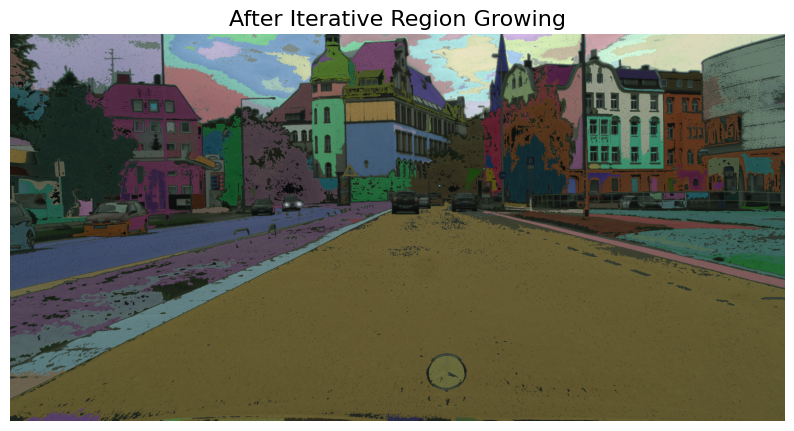

Merged into 49 regions.


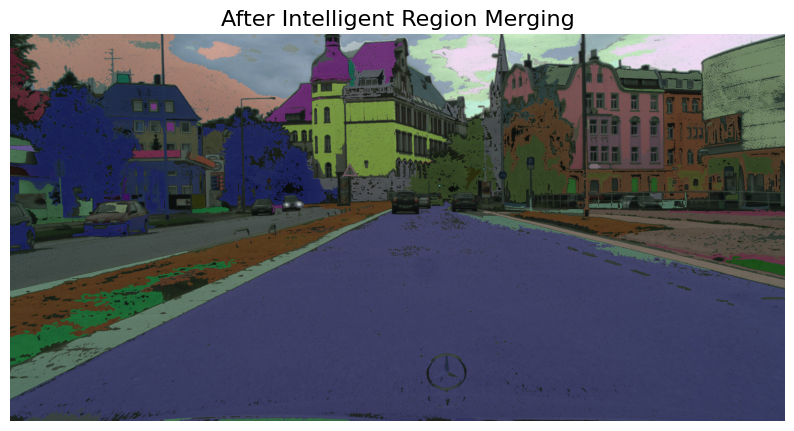

Final segmentation resulted in 49 regions after merging.


In [ ]:
pipeline = SegmentationPipeline(image_path)
merged_segmented, merged_num_labels, image_rgb, gradient_magnitude, basins_mask = pipeline.run()

## 3 - Postprocess the segmentation map

In [ ]:
class SegmentationPostprocessor:
    def __init__(self, selem_size=5, min_size=50):
        self.selem_size = selem_size
        self.min_size = min_size

    def refine_segments(self, segmented):
        selem = footprint_rectangle((self.selem_size, self.selem_size))
        refined = np.zeros_like(segmented)

        for label_val in np.unique(segmented):
            if label_val == 0:
                continue
            mask = segmented == label_val
            mask_closed = closing(mask, selem)
            mask_opened = opening(mask_closed, selem)
            refined[mask_opened] = label_val

        refined = remove_small_objects(refined, min_size=self.min_size, connectivity=2)
        return refined.astype(np.int32)

    def extract_contours(self, refined):
        all_contours = []
        all_hierarchies = []

        for label_val in np.unique(refined):
            if label_val == 0:
                continue

            mask = np.uint8((refined == label_val)) * 255
            contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            all_contours.extend(contours)
            if hierarchy is not None:
                all_hierarchies.extend(hierarchy[0])

        print(f"Total number of contours found: {len(all_contours)}")
        return all_contours, all_hierarchies

    def extract_region_properties(self, contours, image_shape):
        properties = []
        for idx, cnt in enumerate(contours):
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                centroid_x = int(M["m10"] / M["m00"])
                centroid_y = int(M["m01"] / M["m00"])
            else:
                centroid_x, centroid_y = 0, 0

            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h if h != 0 else 0
            rect_area = w * h
            extent = float(area) / rect_area if rect_area != 0 else 0

            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            solidity = float(area) / hull_area if hull_area != 0 else 0

            equi_diameter = np.sqrt(4 * area / np.pi)
            circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

            properties.append({
                'label': idx + 1,
                'area': area,
                'perimeter': perimeter,
                'centroid_x': centroid_x,
                'centroid_y': centroid_y,
                'bounding_x': x,
                'bounding_y': y,
                'bounding_width': w,
                'bounding_height': h,
                'aspect_ratio': aspect_ratio,
                'extent': extent,
                'solidity': solidity,
                'equivalent_diameter': equi_diameter,
                'circularity': circularity
            })
        properties_df = pd.DataFrame(properties)
        return properties_df

    def visualize_refined_segments(self, refined, step_title):
        num_labels = refined.max() + 1
        cmap = colors.ListedColormap(np.random.rand(num_labels, 3))
        plt.figure(figsize=(10, 10))
        plt.imshow(refined, cmap=cmap)
        plt.title(step_title, fontsize=16)
        plt.axis('off')
        plt.show()

    def visualize_regions(self, img_rgb, contours, properties_df, step_title):
        img_copy = img_rgb.copy()
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img_copy)
        for cnt in contours:
            cv2.drawContours(img_copy, [cnt], -1, (0, 255, 0), 2)
        ax.imshow(img_copy)
        ax.set_title(step_title, fontsize=16)
        ax.axis('off')
        plt.show()

    def postprocess_segments(self, segmented, img_rgb):
        save_path="/content/region_properties.csv"

        # Step 1: Refine segments
        refined = self.refine_segments(segmented)

        # Step 2: Extract contours
        contours, hierarchy = self.extract_contours(refined)

        # Step 3: Extract region properties and save them to a CSV file
        properties_df = self.extract_region_properties(contours, img_rgb.shape)
        properties_df.to_csv(save_path, index=False)
        print(f"Region properties saved to {save_path}")
        self.visualize_regions(img_rgb, contours, properties_df, "Extracted Regions with Contours")

        return properties_df, contours, refined

Total number of contours found: 229
Region properties saved to /content/region_properties.csv


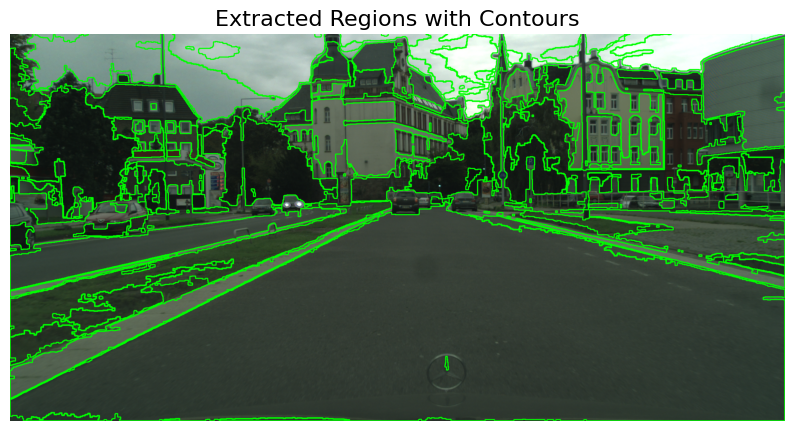

In [ ]:
postprocessor = SegmentationPostprocessor(selem_size=5, min_size=50)
properties_df, contours, refined = postprocessor.postprocess_segments(merged_segmented, image_rgb)

## 4 - Evaluate the segmentation map

In [ ]:
class SegmentationEvaluator:
    def __init__(self):
        pass

    def load_color_annotation(self, color_annotation_path):
        color_gt = cv2.imread(color_annotation_path)
        color_gt = cv2.cvtColor(color_gt, cv2.COLOR_BGR2RGB)
        colors_arr = color_gt.reshape(-1, 3)
        unique_colors, inverse = np.unique(colors_arr, axis=0, return_inverse=True)
        gt_labels = inverse.reshape(color_gt.shape[:2])
        return gt_labels

    def evaluate_clustering_metrics(self, refined, gt_labels):
        assert refined.shape == gt_labels.shape, "Predicted and ground truth images must have the same dimensions."
        gt_flat = gt_labels.flatten()
        pred_flat = refined.flatten()
        ari = adjusted_rand_score(gt_flat, pred_flat)
        nmi = normalized_mutual_info_score(gt_flat, pred_flat)
        print(f"Adjusted Rand Index (ARI): {ari:.4f}")
        print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
        return ari, nmi

    def visualize_comparison(self, original_color_annotation, refined, step_title="Ground Truth vs Predicted Segmentation"):
        unique_labels = np.unique(refined)
        num_labels = len(unique_labels)
        np.random.seed(42)
        colors_list = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)
        max_label = refined.max()
        color_map = np.zeros((max_label + 1, 3), dtype=np.uint8)
        color_map[unique_labels] = colors_list
        refined_color = color_map[refined]

        plt.figure(figsize=(16, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_color_annotation)
        plt.title("Original Color Annotation", fontsize=14)
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(refined_color)
        plt.title("Predicted Refined Segmentation", fontsize=14)
        plt.axis("off")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle(step_title, fontsize=16)
        plt.show()

    def evaluate_and_visualize(self, refined, color_annotation_path, step_title="Ground Truth vs Predicted Segmentation"):
        # Step 1: Load and convert the color annotation image
        original_color_annotation = cv2.imread(color_annotation_path)
        original_color_annotation = cv2.cvtColor(original_color_annotation, cv2.COLOR_BGR2RGB)

        # Step 2: Get ground truth labels
        gt_labels = self.load_color_annotation(color_annotation_path)
        assert refined.shape == gt_labels.shape, "Predicted and ground truth images must have the same dimensions."

        # Step 3: Evaluate clustering metrics
        print("=== Clustering-Based Metrics ===")
        self.evaluate_clustering_metrics(refined, gt_labels)
        self.visualize_comparison(original_color_annotation, refined, step_title)

=== Clustering-Based Metrics ===
Adjusted Rand Index (ARI): 0.5243
Normalized Mutual Information (NMI): 0.5304


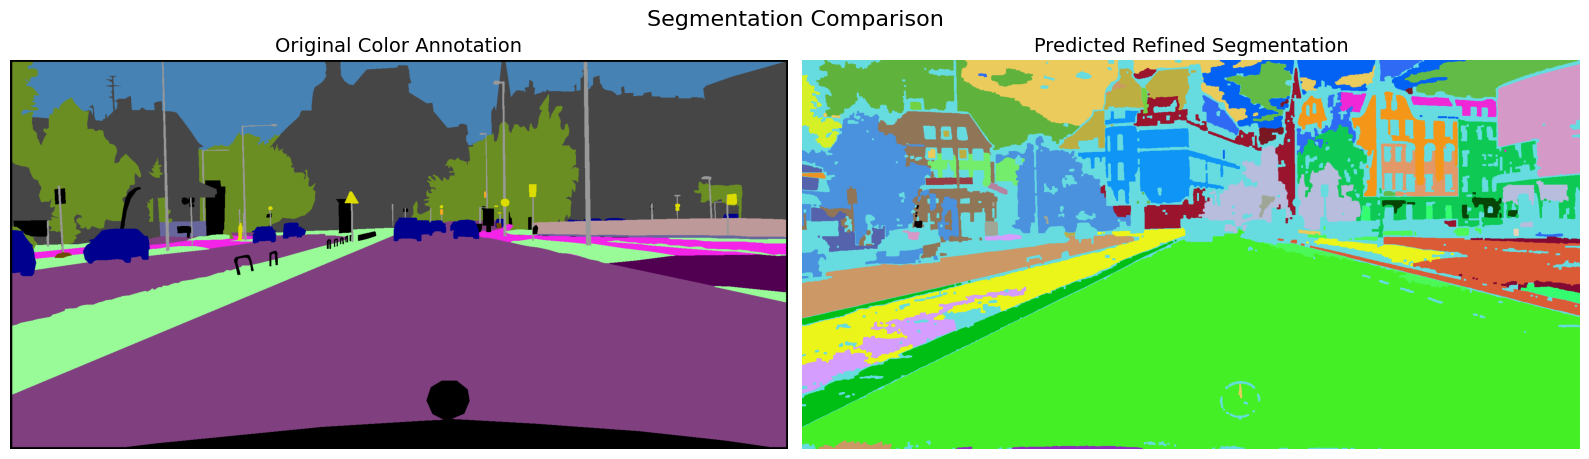

In [ ]:
evaluator = SegmentationEvaluator()
evaluator.evaluate_and_visualize(refined, color_annotation_path, step_title="Segmentation Comparison")